[20220924]

# 2. Model 6

After Preparation ready. Build and train the model in here. its using LSTM one layer. with data gen4

## Goal
Find patterns on the features for target

## Plan
Checklist what will be done on the notebook :

        [ ] Get Data
        [ ] Modelling
        [ ] Evaluation

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
from statsmodels.tsa.arima.model import ARIMA
import sys
sys.path.insert(1,'../../src/')


In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model

from sklearn.model_selection import train_test_split

In [3]:
with open("../../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

PATH_RAW = config['path']['raw']
PATH_INTERIM = config['path']['interim']
PATH_PROCESSED = config['path']['processed']
# PATH_MODEL = config['path']['artifact']+os.getcwd().split('\\')[-1]+'/'
PATH_MODEL = config['path']['artifact']+'iteration_3'+'/'
PATH_UDF = config['path']['udf']

In [4]:
%matplotlib inline

## Get Data

In [5]:
Xt, yt, Xo, yo = joblib.load(PATH_INTERIM+'feat_target_gen4_iter3.pkl')
Xt = Xt.astype("float32")
yt = yt.astype("float32")

Xo = Xo.astype("float32")
yo = yo.astype("float32")

In [6]:
Xt.shape

(386396, 15, 2)

In [7]:
yt.shape

(386396, 1)

In [8]:
SEQ = Xt.shape[1]

In [9]:
## not the best way to split time series dataset
x_tr, x_test, y_tr, y_test = train_test_split(
    Xt, yt, test_size=0.25, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x_tr, y_tr, test_size=0.2, random_state=42)

## Model 1

In [10]:
# os.environ["CUDA_VISIBLE_DEVICES"] 

In [11]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
SEQ

15

In [13]:
mod_ts = Sequential()
mod_ts.add(LSTM(128, input_shape=(SEQ, 2), return_sequences=True))
mod_ts.add(LSTM(64))
mod_ts.add(Dense(32, activation='relu'))
mod_ts.add(Dense(16, activation='relu'))
mod_ts.add(Dense(8, activation='relu'))
mod_ts.add(Dense(4, activation='relu'))
mod_ts.add(Dense(1, activation='linear'))


In [14]:
early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=6) 

check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'ws_data_model6_iter3.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)

opt = tf.keras.optimizers.Adam(learning_rate=0.0004)

mod_ts.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [15]:
history = mod_ts.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stop,check_p]
)

Epoch 1/50
1812/1812 [==============================] - 21s 12ms/step - loss: 0.7287 - the_rmse: 0.8536 - the_mape: 144171.4375 - val_loss: 0.6877 - val_the_rmse: 0.8293 - val_the_mape: 81826.9922
Epoch 2/50
1812/1812 [==============================] - 20s 11ms/step - loss: 0.6666 - the_rmse: 0.8165 - the_mape: 132146.8594 - val_loss: 0.6445 - val_the_rmse: 0.8028 - val_the_mape: 84060.5234
Epoch 3/50
1812/1812 [==============================] - 20s 11ms/step - loss: 0.6200 - the_rmse: 0.7874 - the_mape: 142198.2344 - val_loss: 0.6120 - val_the_rmse: 0.7823 - val_the_mape: 128231.4141
Epoch 4/50
1812/1812 [==============================] - 21s 11ms/step - loss: 0.5943 - the_rmse: 0.7709 - the_mape: 134888.7969 - val_loss: 0.5928 - val_the_rmse: 0.7700 - val_the_mape: 100964.6250
Epoch 5/50
1812/1812 [==============================] - 20s 11ms/step - loss: 0.5735 - the_rmse: 0.7573 - the_mape: 137392.9219 - val_loss: 0.5690 - val_the_rmse: 0.7543 - val_the_mape: 137615.7344
Epoch 6/50
1

## Eval

<AxesSubplot:>

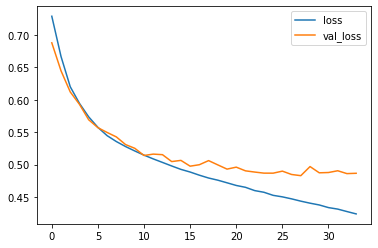

In [16]:
df_epoch_hist = pd.DataFrame(history.history)
df_epoch_hist[['loss','val_loss']].plot()

In [17]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'ws_data_model6_iter3.h5',compile=False)

In [18]:
model_load.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 128)           67072     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5

In [19]:
model_load.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [20]:
model_load.evaluate(x_test,y_test)

3019/3019 [==============================] - 15s 5ms/step - loss: 0.4888 - the_rmse: 0.6992 - the_mape: 105501.2812


[0.4888346493244171, 0.6991671323776245, 105501.28125]

In [21]:
model_load.evaluate(Xo,yo)

1250/1250 [==============================] - 6s 5ms/step - loss: 0.4490 - the_rmse: 0.6700 - the_mape: 110937.8203


[0.44896388053894043, 0.6700476408004761, 110937.8203125]